<center> <h2> Approximation Stochastique </h2> </center>

Les méthodes d'approximation stochastique sont extrêmement utilisées dans les algorithmes de machine learning. Elles permettent de résoudre des problèmes d'optimisation et de point fixe sur des données contenant du bruit. En ingénierie, la plupart des problèmes d'optimisation reposent sur des modèles dont on ne connait pas l'expression exacte mais pour lesquelles on dispose de mesures bruitées. Il parait donc utile de se pencher sur ces méthodes initialement proposé par Robbins-Monro en 1951. Le déroulement de ce notebook est linéaire. On commence par comprendre l'algorithme fondateur puis on avance incrémentalement vers les algorithmes d'optimisation.

<div class="alert alert-success" style="margin-top: 1em">
**Ce qu'il faut retenir**<br/>
Les méthodes d'approximation stochastique :
<ul>
<li> reposent sur des observations bruitées d'une fonction que l'on ne peut pas calculer </li>
<li> sont des méthodes itératives</li>
<li> sont utilisées en apprentissage pour minimiser des fonctions de risque </li>
<li> sont pertinentes pour cette application mais peu compétitives sur d'autre problèmes d'optimisation</li>
</ul>
</div>

### Table des matières

1. Algorithme de Robbins-Monro 
2. Lien avec les problèmes d'optimisation
    - Algorithm de Kierfer-Wolfowitz
    - Approximation stochastique par perturbations simultanées
    - Approximation du gradient lors de l'apprentissage
1. Application à l'économie

In [17]:
import pylab
import numpy as np
import matplotlib.pyplot as plt
import math
np.random.seed(76523654)

### Introduction : Fonction bruitée
Dans un premier temps, nous allons illustrer une fonction bruitée et voir les contraintes liées à la manipulation de ces types de fonction. <br> Une fonction bruitée est une fonction perturbée par un bruit indéterminé à chaque évaluation, ce qui la rend assez difficile à manipuler.
<br> Ce type de fonction est très fréquent dans les secteurs liés au traitement de signaux.

In [18]:
##Définition de la fonction bruitée
def f(x):
    return 0.1*x**2-2.6*x-1.5

def noisy_func(x):
    return np.random.normal(loc = f(x), scale = 1)

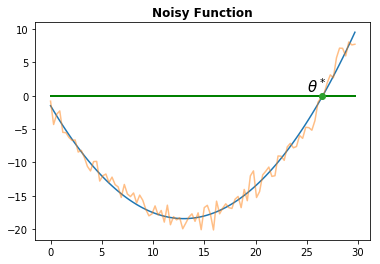

In [19]:
X = np.arange(100)*0.3
normal = f(X)
noisy = np.zeros(len(X))

for i in range(len(X)):
    noisy[i] = noisy_func(X[i])
    
##Représentation graphique de la fonction 
plt.plot(X,normal)
plt.plot(X,noisy,alpha=0.5)
plt.plot(X,[0]*len(X),'g-',linewidth=2.0)
plt.plot(26.5,0,marker='o')
plt.text(25, 0.5, r'$\theta^*$',fontsize=15)
plt.title('Noisy Function',y=1,fontweight='bold')
plt.show()



<div class = "alert alert-danger">
Comment procéderiez-vous pour déterminer la solution de l'équation f(a)=4 à partir du graphe, par exemple? 

Intuitivement, pourriez-vous déterminer graphiquement le minimum global de la fonction f? 

</div>

Réponse :

### 1. Algorithme de Robbins-Monro


Soit $f$ une fonction bruitée.  Soit une constante $\alpha$ telle que l'équation $f(\theta)=\alpha$ admette une unique solution $\theta^*$ que nous souhaitons déterminer. Supposons également que $f$ ne soit pas directement observable, mais nous pouvons observer les valeurs de la variable aléatoire $N(\theta)$ telle que $\mathbb E[N(\theta)]=f(\theta)$. L'algorithme de Robbins-Monro<sup>[1]</sup> respose sur des itérations de $\theta$:

$\theta_{n+1}=\theta_n-a_n\cdot(N(\theta_n)-\alpha)$

où $(a_i)$ est une suite positive qui remplit les conditions suivantes: $ \sum\limits_{n=0}^{\infty}a_n = \infty$ et $\sum\limits_{n=0}^{\infty}a^2_n < \infty$

Blum a ensuite proposé des garanties sur la probabilité de convergence. Il postule que la suite $(\theta_n)$ converge vers la racine unique $\theta^*$ avec une probabilité de 1 dans $L^2$ sous les hypothèses suivantes:

* $N(\theta)$ est uniformément bornée
* $f(\theta)$ est non décroissante
* $f'(\theta^*)$ existe et est définie positive


La suite $a_n=\frac{a}{n}$ avec $a>0$ est suggérée par Robbins-Monro.

<div class="alert alert-warning">
**Exercice**: Implémenter l'algorithme de Robbins-Monro pour trouver la racine du polynome donné en introduction
</div> 

In [20]:
def robbins_monro(theta_0,n_iter,alpha,func):
    #Variables à utiliser :
    #theta_liste :  liste des theta possibles sur laquelle on va itérer
    #n_iter: le nombre d'itérations
    theta_liste = [theta_0]*n_iter
    ### A COMPLETER
    for i in range(n_iter-1):
        a_n= 1/(i+1)
        theta_liste[i+1] = theta_liste[i] - a_n*func(theta_liste[i]-alpha) 
    return theta_liste



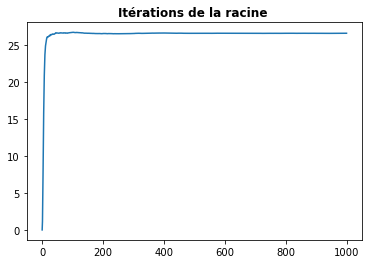

In [21]:
theta_list = robbins_monro(0,1000,0,noisy_func)
plt.plot(theta_list)
plt.title('Itérations de la racine ',y=1,fontweight='bold')
plt.show()

<div class ="alert alert-danger">

Vous pouvez jouer sur les paramètres suivants :
<ul>
<li>l'estimation initiale $\theta_0$  
<li> le nombre d'itérations
<li>la function bruitée
</ul>

Que remarquez-vous?
</div>

On remarque que l'algorithme de Robbins-Monro converge bien plus rapidement vers la solution en l'approchant par valeurs inférieures que par valeurs supérieurs. Cela illustre la probabilité plus grande de convergence sous l'hypothèse de non-décroissance proposé par Blum.

### 2. Lien avec les problèmes d'optimisation

#### Algorithme de Kiefer-Wolfowitz

L'algorithme de Kiefer-Wolfowitz <sup>[1]</sup> , proposé en 1952 découle tout droit de celui de Robbins-Monro (seulement un an après). Son but n'est pas de trouver la racine d'un polynome mais d'approximer stochastiquement le maximum ou le minimum d'une fonction. 

Soit la fonction $M$ qui admet un maximum en $x^{*}$. On suppose que $M(x)$ est inconnue mais on dispose d'observations $N(x)$ telles que $\mathbb{E}[N(x)]=M(x)$.

L'agorithme consite alors en à une descente de gradient où le gradient est estimé par une différence finie centrée du premier ordre. Les itérations sont données par :

$$x_{n+1}=x_n+a_n\left(\frac{N(x_n+c_n)-N(x_n-c_n)}{2c_n}\right)$$ 

La suite $\{a_n\}$ représente la taille des pas à chaque itération et peut être perçu comme un terme de "confiance" en l'estimation du gradient. La suite $\{c_n\}$ correspond à la largeur de la différence centrée.

Pour ce théorème, Blum a prouvé que la suite des $x_n$ converge presque surement vers $x^*$ si :
* $\text{Var}(N(X))\leq S \leq \infty$
* La fonction $M(x)$ admet un unique maximum (minimum) et est fortement concave (convexe)
* $\{a_n\}$ et $\{c_n\}$ sont telles que :
    - $c_n \leftarrow 0$ as $ n \leftarrow \infty$
    - $\sum_{n=0}^\infty a_n=\infty$
    - $\sum_{n=0}^\infty a_nc_n< \infty$
    - $\sum_{n=0}^\infty a_n^2c_n^{-2}< \infty$
    
Ces conditions permettent donc de trouver le maximum ou le minimum d'une fonction $M(x)$ en utilisant les observations bruitées $N(x)$ de cette dernière.

<div class ="alert alert-danger">
Quelles sont les limites de cette méthode pour l'estimation du gradient d'une fonction de nombreuses variables ?
</div>

Si le gradient à évaluer dépend d'un nombre de variables $k$ alors l'approximation du gradient nécessite $2k$ évaluations de la fonction $N$. Cela peut être problématique lorsque $k$ est grand.

#### Approximation stochastique par perturbations simultanées

La méthode de Kiefer-Wolfowitz consiste donc en une simple différence finie centrée sur une fonction bruitée. Il faut donc $p$ différence finie pour estimer le gradient en dimension $p$. En effet l'estimation de la i-ème composante du gradient est :

**DF : ** $ \quad(\hat{g}_n(x_n))_i=\dfrac{N(x_n+c_n)-N(x_n-c_n)}{2c_n}$

Pour accélérer le processus d'estimation du gradient on peut utiliser la méthode de perturbation simultanée (PS) <sup>[2]</sup>. Pour ce faire on définie $\Delta_n$ comme un vecteur de perturbation aléatoire dont les valeurs sont comprises entre 0 et 1. L'estimation de la i-ème composante du gradient devient :

** PS : ** $\quad (\hat{g}_n(x_n))_i=\dfrac{N(x_n+c_n\Delta_n)-N(x_n-c_n\Delta_n)}{2c_n(\Delta_n)_i}$

Ainsi si l'estimation du gradient en différence finie requiert $2p$ estimation de la fonction $N$, elle n'en demande que 2 en perturbation simultanée. 

<div class= "alert alert-warning">

** Exercice : ** On se propose d'approcher un polynome uniquement à partir d'une observation bruitée de ce dernier afin d'illustrer l'efficacité de la méthode de perturbations simultanées.
<div>


On cherche donc le polynome $p$ de degré 2, $p \in \mathbb{P}^2$, qui se cache derrière la fonction bruitée que l'on a généré dans notre introduction. En reprenant les notations définies précédemment, on cherche $\theta \in \mathbb{R}^3$ tel que $\hat{p(\theta,x)}\approx M(x)$ sachant qu'on n'utilise que $N(x)$.
On définie donc la fonction de coût (ou de risque):
$$ R(\theta)=\sum_{k=0}^K(\hat{p(\theta,x_k)}-N(x_k))^2$$
qui représente l'écart entre l'estimation du polynome et la fonction $N$ en chaque point $x_k$ de la discrétisation utilisée. L'évaluation du gradient se fait alors sur trois dimensions $\dfrac{\partial R(\theta)}{\partial \theta_0}$, $\dfrac{\partial R(\theta)}{\partial \theta_1}$ et $\dfrac{\partial R(\theta)}{\partial \theta_2}$

L'approximation du gradient s'écrit alors : $(\hat{g}_n(\theta_n))_i=\dfrac{R(\theta_n+c_n\Delta_n)-R(\theta_n-c_n\Delta_n)}{2c_n(\Delta_n)_i}$

In [22]:
fitfunc = lambda p, x: p[0] * x * x + p[1] * x + p[2]
errfunc = lambda p, x, y, noise_var: np.sum((fitfunc(p, x) - y) ** 2 / noise_var ** 2)
def calc_loss(theta,x_arr,obs,noise_var):
    return errfunc(theta,x_arr,obs,noise_var)

In [23]:
p_in=[0.1, -2.6, -1.5]
noise_var=1
x_arr = np.arange(100) * 0.3
obs = p_in[0] * x_arr ** 2 + p_in[1] * x_arr + p_in[2]
noise = np.random.normal(size=100) * noise_var  # add some noise to the obs
obs += noise

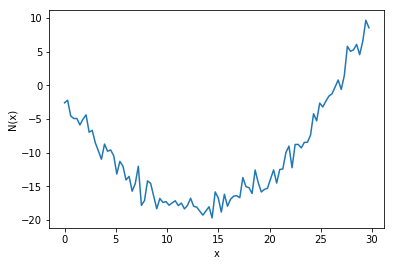

In [24]:
plt.plot(x_arr,obs)
plt.xlabel('x')
plt.ylabel('N(x)')
plt.show()

L'algorithme d'aproximation stochastique par perturbations simultanées nécessite de définir les hyperparamètres suivant:
   * $n_{max}$, le nombre maximal d'itération
   * $\alpha$ qui permet de défnir $a_n=\alpha \frac{1}{n+n_{max}/10}$
   * $\gamma$ qui permet de définir $c_n=\left(\frac{1}{n}\right)^{\gamma}$
   
On initilaise enfin $\theta_0$ aléatoirement. Il convient de noter la petite ruse qui consiste à ajouter le nombre d'itérations maximum possible dans la définition des $a_n$. Cela signifie que si l'on dispose de peu d'itérations les directions indiqués par le gradient seront suivies fortement à chaque itération.

In [25]:
# Initialisation
theta_0 = np.random.rand(3)
num_p = theta_0.shape[0]
n_iter=0
theta=theta_0
R_old=calc_loss(theta,x_arr,obs,noise_var)
alpha=1e-3
gamma=0.15

max_iter=1000000
theta_saved = theta_0 * 100
R_new=1000
Rlist=[]
ghatlist=[]

In [26]:
while (np.linalg.norm(theta_saved - theta) / np.linalg.norm(theta_saved) > 1e-10) and (n_iter < max_iter):
    theta_saved=theta
    ak=1/(n_iter+1+max_iter/10)*alpha
    ck=1/(n_iter+1)**(gamma)
    ghat=0 # initial gradient estimate
    ### A COMPLETER
    #-------------------
    delta = (np.random.randint(0, 2, num_p) * 2 - 1)
    
    theta_plus = theta + ck * delta
    theta_minus = theta - ck * delta
    
    R_plus = calc_loss(theta_plus,x_arr,obs,noise_var)
    R_minus = calc_loss(theta_minus,x_arr,obs,noise_var)
    ghat =(R_plus - R_minus) / (2. * ck * delta)

    theta_new = theta - ak * ghat
    R_new=calc_loss(theta_new,x_arr,obs,noise_var)
    #-------------------
    Rlist.append(R_new)
    ghatlist.append(ghat[1])
    theta=theta_new
    n_iter+=1
xsol=theta
ysol=xsol[0]*x_arr**2 + xsol[1]*x_arr +xsol[2]

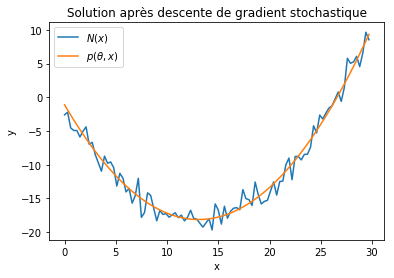

In [27]:
plt.plot(x_arr,obs,label="$N(x)$")
plt.plot(x_arr,ysol,label="$p(θ,x)$")
plt.title("Solution après descente de gradient stochastique")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.show()

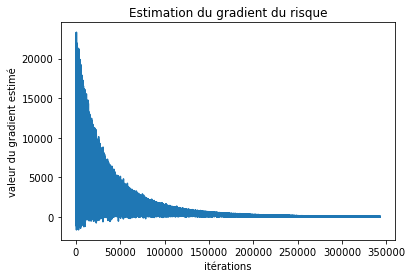

In [28]:
plt.plot(ghatlist[1000:len(ghatlist)-1])
plt.title("Estimation du gradient du risque")
plt.xlabel("itérations")
plt.ylabel("valeur du gradient estimé")
plt.show()

#### Lien avec l'approximation du gradient lors de l'apprentissage

En apprentissage, on souhaite souvent minimiser une fonction de risque $R$ en ajustant les paramètres d'un estimateur. Prenons le cas d'un réseau de neuronnes $f$. On souhaite minimiser le risque empirique $R$ que notre réseau se trompe lors de sa prédiction. Si l'on se réfère à notre cours sur les réseaux de neuronnes on a :

<center>$R(\theta)=\frac{1}{n}\sum_{i=1}^n\sum_{k=1}^K(y_{ik}-f_k(x_i))^2=\dfrac{1}{n}\sum_{i=1}^nR_i(\theta)$

<center/n>

La mise à jour des poids du réseau se fait via la règle suivante : $\theta \leftarrow \theta + \gamma\dfrac{\partial R}{\partial \theta}$

Le gradient est donc calculé **pour tous les échantillons** de la base de donnée avant la mise à jour des $\theta$. Lorsque les données d'entrainement sont nombreuses, la formation du batch des données est trop longue et ne permet pas d'adapter le modèle en ligne. C'est pourquoi on utilise une approximation stochastique du gradient. 

La **descente de gradient sochastique** permet d'obtenir l'information du gradient du risque empirique $\frac{\partial R}{\partial \theta}$ en calculant le gradient $\frac{\partial R_i}{\partial \theta}$ après chaque passage d'un exemple $x_i$ dans la base de donnée. La mise à jour des poids devient :

$\theta \leftarrow \theta + \gamma\dfrac{\partial R_i}{\partial \theta}$

Le risque empirique $R(\theta)$ n'étant que la moyenne des $R_i(\theta)$, on peut donc percevoir $R_i$ comme une information bruitée de $R$. Le théorème de Robbins-Monro s'applique donc et la convergence est garantie à condition que la suite des $\gamma$ respecte les conditions du théorème.

### 3. Application à l'économie

Pour terminer ce notebook, on se propose d'appliquer l'algorithme de Robbins-Monro à la résolution d'un problème d'économie tiré de [4].

Soit $Elios$, une entreprise spécialisée dans la vente et qui dispose de $N$ centres géographiques, dans lesquels sont répartis les clients.

Soit $q$ le niveau optimal d'éléments produits déstinés à la vente .

Chaque centre a un nombre de clients potentiel éstimé à $C$.

Le nombre de clients potentiels est directement corrélé au niveau $x$ de l'action publicitaire investie par l'entreprise dans chaque centre géographique. Le nombre de client effectif est donc $CK(x)$ où $K(x)$ peut avoir une distribution aléatoire.  

A long terme, l'objectif de l'entreprise est d'uniformiser les ventes de ses diffèrents centres géographiques; c'est à dire vendre dans chaque centre une quantité qui avoisine $q/N$ sous l'hypothèse suivante : $q/N <<C$.

Le but de cet exercice est de trouver l'action publicitaire $x$ optimale permettant d'atteindre cet objectif.

La fonction aléatoire $K$ est définie de la manière suivante :

In [29]:
q=4000
N=50
C=1000

def K(x):
    return np.random.normal(loc = np.arctan(0.05*x)/math.pi , scale = 0.05)

On vérifie que $q/N<<C$

In [30]:
print(q/N)
print(C)

80.0
1000


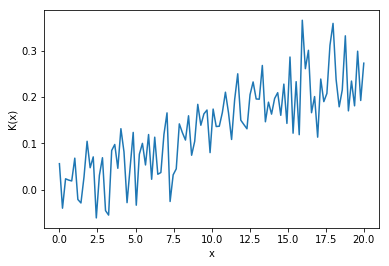

In [31]:
x=np.linspace(0,20,100)
plt.plot(x,K(x))
plt.xlabel('x')
plt.ylabel('K(x)')
plt.show()

<div class= "alert alert-warning">

** Exercice : ** Définir la fonction Y(x) permettant de trouver le niveau d'action publicitaire $x$ optimal. Puis utiliser l'algorithme de Robbins-Monro pour trouver $x$.
<div>



In [ ]:
def Y(x):
    ### A COMPLETER
    return C*K(x)-q/N

x_sol=robbins_monro(0,100,0,Y)
x_sol=x_sol[len(x_sol)-1]

### A COMPLETER
plt.plot(x,Y(x))
plt.scatter(x_sol,0)
plt.show()


### Références

[1] : https://en.wikipedia.org/wiki/Stochastic_approximation

[2] : https://en.wikipedia.org/wiki/Simultaneous_perturbation_stochastic_approximation

[3] : https://github.com/jgomezdans/spsa

[4] : _L'approximation et l'optimisation stochastiques en économie : deux exemples, Max Pinhas, Revue économique,  Année 1973,  Volume 24  Numéro 1  pp. 176-182_

[5] : _Stochastic Approximation and Recursive Algorithms and Applications, Harold J. KushnerG. George Yin, 2003_